# **Segundo Examen Parcial**
## **Aprendizaje Automático y Análisis de Datos**

*Mayo 3 de 2021*
- Nicolás Delgado,  ```nsdr1228 <at> gmail.com```
- Camila Paladines,  ```camilapaladines27 <at> gmail.com```


Para el correcto funcionamiento del código, debe instalarse la librería *imblearn* en su versión ```0.6.2```, ya que será usada en la segunda y tercera iteración, con el objetivo de balancear las clases, haciendo over-sampling de la clase minoritaria.

> **NOTA:** Debe tenerse bastante cuidado de que ***NO*** se vaya a actualizar la librería de scikit-learn (sklearn), ya que hay problemas con *SearchGridCV* en versiones posteriores a la ```0.22.2``` (esta es la que trae por defecto Google Colab)

In [ ]:
# Si se ejecuta desde colab, puede correrse la siguiente instrucción para instalar la librería
!pip install imbalanced-learn==0.6.2

## **Primera iteración**

### **Entendimiento y preparación de los datos**

In [ ]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from seaborn import heatmap, barplot
from sklearn.preprocessing import scale, LabelEncoder, quantile_transform
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from copy import deepcopy
from imblearn.over_sampling import SMOTE

# Nombres de los atributos numéricos y categóricos
numeric_att = ['age', 'bp', 'sg', 'al', 'su','bgr', 'bu', 'sc', 'sod', 'pot', 
               'hemo', 'pcv', 'wbcc', 'rbcc']

categorical_att = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 
                   'ane', 'class']

# Carga los datos (desde un repositorio en GitHub)
url="https://raw.githubusercontent.com/paladinescamila/Parcial-2-AA/main/data.csv"
data = pd.read_csv(url, header=None)

data.columns = ["age", "bp", "sg", "al", "su", "rbc", "pc", "pcc", "ba", "bgr", 
                "bu", "sc", "sod", "pot", "hemo", "pcv", "wbcc", "rbcc", "htn", 
                "dm", "cad", "appet", "pe", "ane", "class"]

data

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,36,1.2,?,?,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,18,0.8,?,?,11.3,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,53,1.8,?,?,9.6,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,26,1.4,?,?,11.6,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55,80,1.020,0,0,normal,normal,notpresent,notpresent,140,49,0.5,150,4.9,15.7,47,6700,4.9,no,no,no,good,no,no,notckd
396,42,70,1.025,0,0,normal,normal,notpresent,notpresent,75,31,1.2,141,3.5,16.5,54,7800,6.2,no,no,no,good,no,no,notckd
397,12,80,1.020,0,0,normal,normal,notpresent,notpresent,100,26,0.6,137,4.4,15.8,49,6600,5.4,no,no,no,good,no,no,notckd
398,17,60,1.025,0,0,normal,normal,notpresent,notpresent,114,50,1.0,135,4.9,14.2,51,7200,5.9,no,no,no,good,no,no,notckd


In [ ]:
# Cantidad de registros y atributos
data.shape

(400, 25)

In [ ]:
# Tipo de los atributos
data.dtypes

age      object
bp       object
sg       object
al       object
su       object
rbc      object
pc       object
pcc      object
ba       object
bgr      object
bu       object
sc       object
sod      object
pot      object
hemo     object
pcv      object
wbcc     object
rbcc     object
htn      object
dm       object
cad      object
appet    object
pe       object
ane      object
class    object
dtype: object

### ***NOTA:***
Como se puede observar en  ```data.dtypes```, todas las columnas tienen sus atributos de tipo string, por lo cual se creará una copia profunda (```deepcopy```) del dataframe original, **NO** se cambiará el original. Solo se creará una copia del mismo para un mejor entendimiento de los datos, ya que resulta imposible hacer diagramas de cajas con datos nulos o faltantes.


In [ ]:
# Creación de una copia del dataframe para analizar los atributos numéricos
filtered_data = deepcopy(data).replace('?', np.nan, inplace=False)

for i in numeric_att:
    filtered_data[i] = pd.to_numeric(filtered_data[i], errors='coerce')

numeric_data = {}
for i in numeric_att:
    numeric_data[i] = filtered_data[i].dropna()

In [ ]:
# Medidas de centralidad y dispersión (atributos numéricos)
filtered_data.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


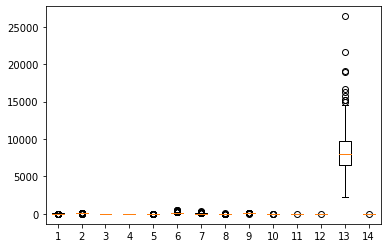

In [ ]:
# Diagrama de cajas y bigotes (atributos númericos)
plt.boxplot((numeric_data['age'], numeric_data['bp'], numeric_data['sg'], numeric_data['al'],numeric_data['su'], 
             numeric_data['bgr'], numeric_data['bu'], numeric_data['sc'], numeric_data['sod'], numeric_data['pot'], 
             numeric_data['hemo'], numeric_data['pcv'], numeric_data['wbcc'], numeric_data['rbcc']))
plt.show()

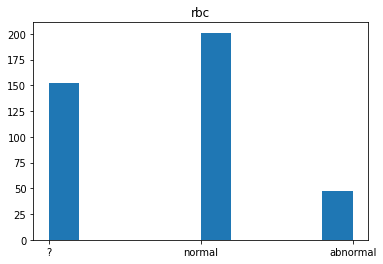

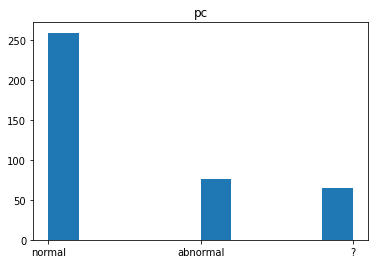

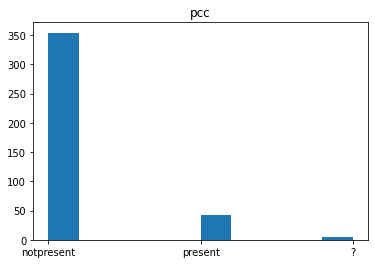

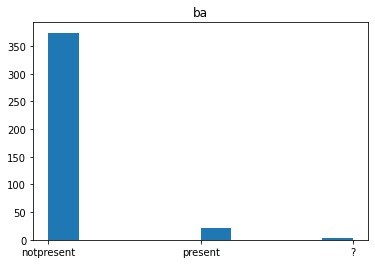

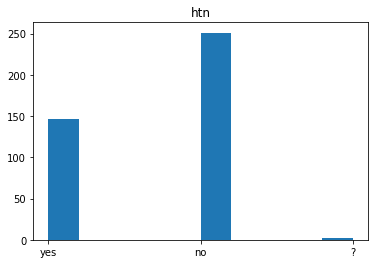

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


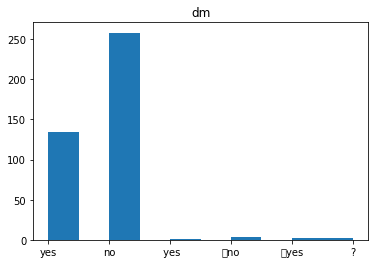

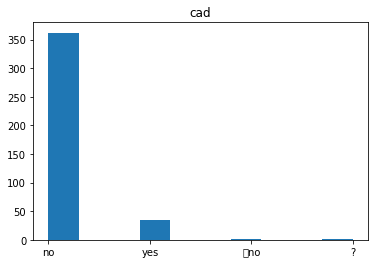

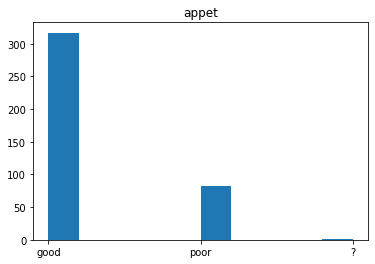

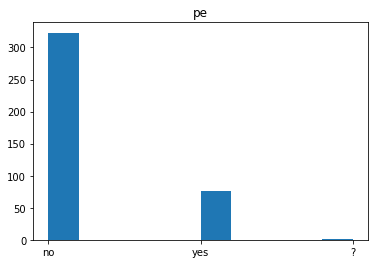

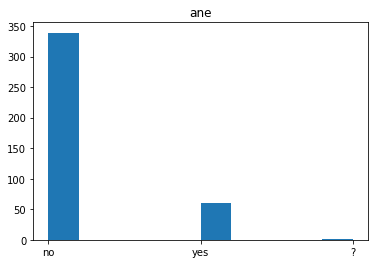

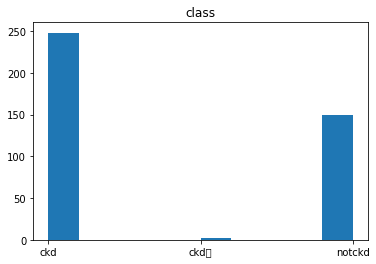

In [ ]:
# Distribución de los datos (atributos categóricos)
for i in categorical_att:
    plt.title(i)
    plt.hist(data[i])
    plt.show()

In [ ]:
# Medidas de centralidad (atributos categóricos)
data.mode()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,60,80,1.020,0,0,normal,normal,notpresent,notpresent,?,?,1.2,?,?,?,?,?,?,no,no,no,good,no,no,ckd


In [ ]:
# Cantidad de duplicados por clase
levels = data.groupby(['class'])
for name, group in levels:
    print(name, group[group.duplicated()].count()[0])

ckd 0
ckd	 0
notckd 0


In [ ]:
# Correlación (tabla)
filtered_data.corr()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
age,1.000000,0.159480,-0.191096,0.122091,0.220866,0.244992,0.196985,0.132531,-0.100046,0.058377,-0.192928,-0.242119,0.118339,-0.268896
bp,0.159480,1.000000,-0.218836,0.160689,0.222576,0.160193,0.188517,0.146222,-0.116422,0.075151,-0.306540,-0.326319,0.029753,-0.261936
sg,-0.191096,-0.218836,1.000000,-0.469760,-0.296234,-0.374710,-0.314295,-0.361473,0.412190,-0.072787,0.602582,0.603560,-0.236215,0.579476
al,0.122091,0.160689,-0.469760,1.000000,0.269305,0.379464,0.453528,0.399198,-0.459896,0.129038,-0.634632,-0.611891,0.231989,-0.566437
su,0.220866,0.222576,-0.296234,0.269305,1.000000,0.717827,0.168583,0.223244,-0.131776,0.219450,-0.224775,-0.239189,0.184893,-0.237448
bgr,0.244992,0.160193,-0.374710,0.379464,0.717827,1.000000,0.143322,0.114875,-0.267848,0.066966,-0.306189,-0.301385,0.150015,-0.281541
bu,0.196985,0.188517,-0.314295,0.453528,0.168583,0.143322,1.000000,0.586368,-0.323054,0.357049,-0.610360,-0.607621,0.050462,-0.579087
sc,0.132531,0.146222,-0.361473,0.399198,0.223244,0.114875,0.586368,1.000000,-0.690158,0.326107,-0.401670,-0.404193,-0.006390,-0.400852
sod,-0.100046,-0.116422,0.412190,-0.459896,-0.131776,-0.267848,-0.323054,-0.690158,1.000000,0.097887,0.365183,0.376914,0.007277,0.344873
pot,0.058377,0.075151,-0.072787,0.129038,0.219450,0.066966,0.357049,0.326107,0.097887,1.000000,-0.133746,-0.163182,-0.105576,-0.158309


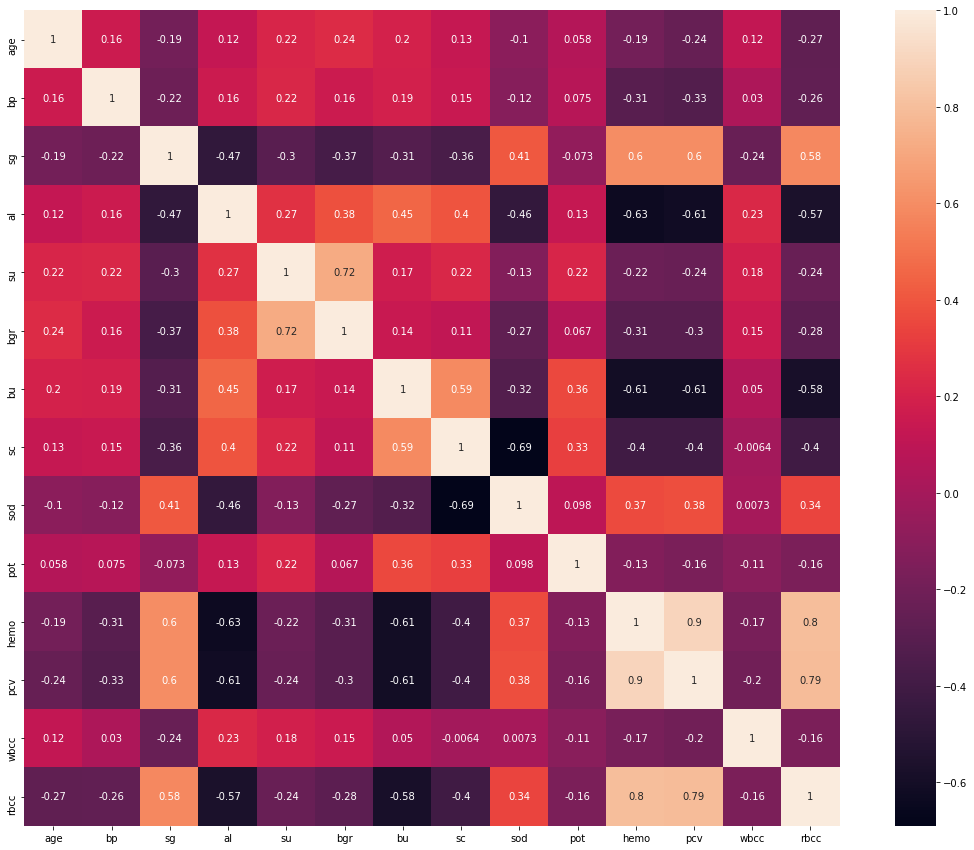

In [ ]:
# Correlación (gráfica)
plt.subplots(figsize=(20,15))
heatmap(filtered_data.corr(), square=True, annot=True)

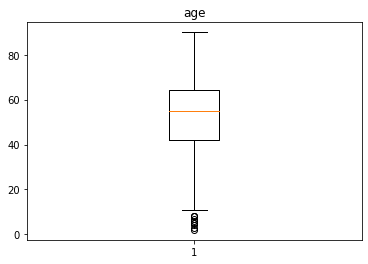

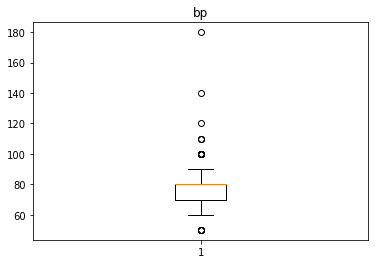

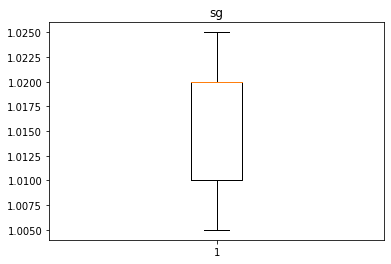

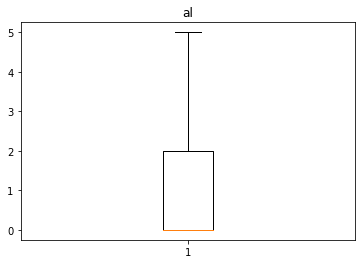

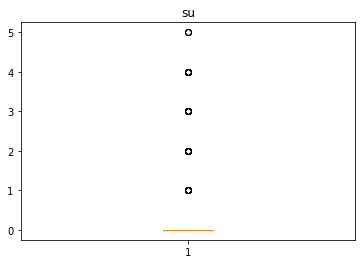

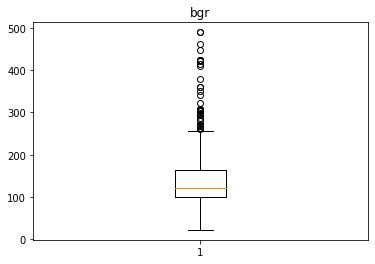

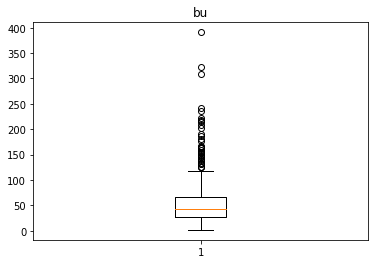

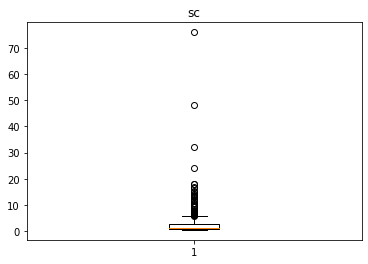

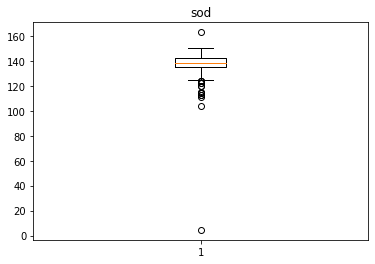

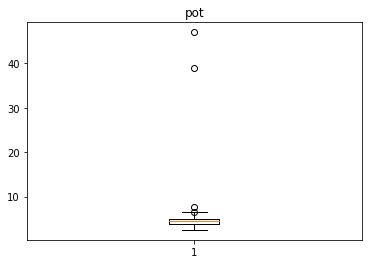

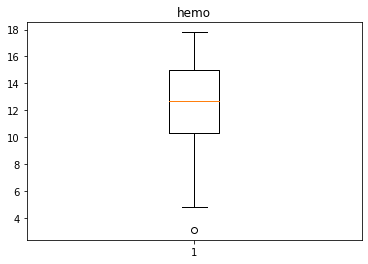

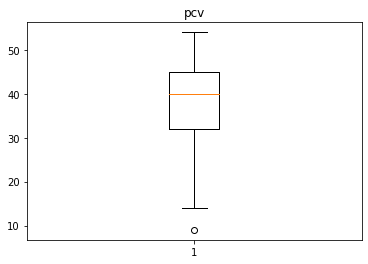

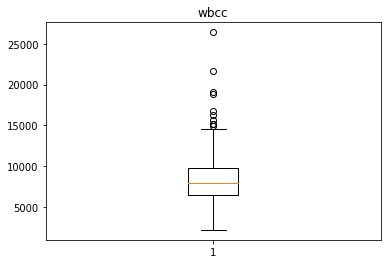

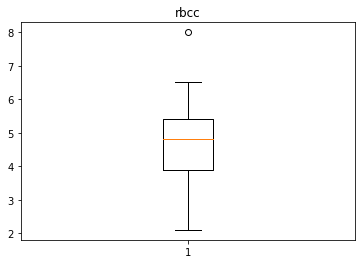

In [ ]:
# Datos atípicos de cada atributo
for i in numeric_att:
    plt.title(i)
    plt.boxplot(numeric_data[i])
    plt.show()

In [ ]:
# Cantidad de registros sin valores atípicos
temp = filtered_data[numeric_att]
temp[(np.abs(stats.zscore(temp)) < 3).all(axis=1)].count()[0]

0

In [ ]:
# Datos faltantes por cada atributo
filtered_data.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [ ]:
# Datos faltantes por clase
g = filtered_data.groupby(['class'])
for name, group in g:
    print(name, group.isnull().sum().sum())

ckd 900
ckd	 8
notckd 104


In [ ]:
# Datos faltantes por clase y por atributo
g = filtered_data.groupby(['class'])
for name, group in g:
    print("\n{}".format(name))
    print(group.isnull().sum(), "\n")


ckd
age        8
bp        10
sg        41
al        40
su        43
rbc      142
pc        55
pcc        0
ba         0
bgr       38
bu        13
sc        12
sod       82
pot       83
hemo      45
pcv       66
wbcc      99
rbcc     123
htn        0
dm         0
cad        0
appet      0
pe         0
ane        0
class      0
dtype: int64 


ckd	
age      0
bp       0
sg       1
al       1
su       1
rbc      1
pc       1
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     1
pcv      1
wbcc     0
rbcc     1
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64 


notckd
age      1
bp       2
sg       5
al       5
su       5
rbc      9
pc       9
pcc      4
ba       4
bgr      6
bu       6
sc       5
sod      5
pot      5
hemo     6
pcv      4
wbcc     7
rbcc     7
htn      2
dm       2
cad      2
appet    1
pe       1
ane      1
class    0
dtype: int64 



In [ ]:
# Cantidad de registros por clase
data['class'].value_counts()

ckd       248
notckd    150
ckd\t       2
Name: class, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


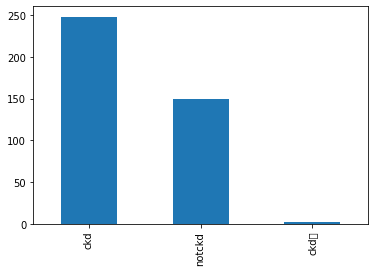

In [ ]:
# Gráfica de la cantidad de registros por clase
data['class'].value_counts().plot(kind='bar')

#### **Conclusiones sobre el entendimiento de los datos**

- No hay registros duplicados.
- Los atributos "pcv" y "hemo" son altamente correlacionados (0.9), por lo que se eliminará uno de ellos.
- Hay bastantes atributos con valores atípicos en ambas clases, pero consideramos que son importantes para la construcción del modelo, por lo que no se van a eliminar.
- Hay 242 registros con al menos un dato faltante.
- Un 62.5% de los registros hacen parte de la clase mayoritaria, por lo que no está completamente balanceado.
- La principal dificultad con el dataset es que hay bastantes datos faltantes.
- No es necesario discretizar algún atributo.
- Es necesario normalizar la mayoría de los atributos.
- Es necesario pasar los atributos categóricos a numéricos.
- Algunos atributos categóricos tienen errores en la transcripción, por ejemplo en las clases en vez de "ckd" en algunos registros está escrito "ckd\t". Este error sucede también en otros atributos.
- Otro problema fue que los atributos numéricos tenían el tipo de dato "string", esto debido a que para los datos faltantes en vez de estar vacío se encontraba el caracter "?", que imposibilitaba el análisis de estos atributos.

#### **Plan de ajuste de datos**

1. Eliminar los registros con 5 o más datos faltantes.
2. Resolver algunos problemas de escritura de los datos.
3. Reemplazar los datos faltantes por la media o la moda según el tipo del atributo.
4. Eliminar el atributo "pcv" para eliminar la correlación con "hemo".
5. Normalizar el atributo "wbcc".
6. Pasar los atributos categóricos a numéricos.

In [ ]:
# Paso 1: Eliminar los registros con 5 o más datos faltantes
data = data.replace('?', np.nan, inplace=False).dropna(thresh=20, inplace=False)

In [ ]:
# Paso 2: Resuelve algunos problemas de escritura de los datos
mapping = {"\tyes": "yes", "\tno": "no", " yes": "yes", " no": "no"}
boolean = ['htn', 'dm', 'cad', 'pe', 'ane']
for i in boolean: data[i] = data[i].replace(mapping)

data['class'] = data['class'].replace({"ckd\t": "ckd"})

for i in numeric_att: data[i] = pd.to_numeric(data[i], errors='coerce')

In [ ]:
# Paso 3: Reemplazar los datos faltantes por la media o la moda
for i in numeric_att:
    data[i].fillna(data[i].mean(), inplace=True)

for i in categorical_att:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [ ]:
# Correlación (gráfica)
plt.subplots(figsize=(20,15))
heatmap(data.corr(), square=True, annot=True)

In [ ]:
# Paso 4: Eliminar el atributo "pcv"
data = data.drop("pcv", axis=1)

In [ ]:
# Paso 5: Normalizar el atributo "wbcc"
data['wbcc'] = scale(data['wbcc'])

In [ ]:
# Paso 6: Pasar los atributos categóricos a numéricos
categorize = data.apply(LabelEncoder().fit_transform)
for i in categorical_att:
    data[i] = categorize[i]

### Entrenamiento de los modelos

In [ ]:
# Separación de los datos
X, y = data.drop('class', axis=1), data['class']
f1s = [0 for _ in range(4)]

# Se fijan los datos de entrenamiento y validación para poder comparar los modelos
train_test = {}
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    train_test[i] = (X_train, X_test, y_train, y_test)

# Imprime las métricas de un modelo
def print_metrics(metrics):

    print("Métrica\t\t  Prom\t  Desv\t  Min\t  Max")
    nombres = ["Precision", "Recall", "F1-score", "Accuracy"]

    print()
    for i in range(4):
        mean = np.mean(metrics[i])
        std = np.std(metrics[i])
        min_ = np.min(metrics[i])
        max_ = np.max(metrics[i])
        if (i != 1):
            print("{}\t{:.5f}\t{:.5f}\t{:.5f}\t{:.5f}".format(nombres[i], mean, std, min_, max_))
        else:
            print("{}\t\t{:.5f}\t{:.5f}\t{:.5f}\t{:.5f}".format(nombres[i], mean, std, min_, max_))

In [ ]:
# Perceptrón Multicapa

parameter_space = [{'hidden_layer_sizes': [(10,10,10,10), (50,50,50,50), (100,100,100)], 
                        'activation': ['logistic', 'tanh', 'relu'], 'max_iter': [700, 1000],
                        }]

metrics = [[] for i in range(4)]

for i in range(10):

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_train, X_test, y_train, y_test = train_test[i][0], train_test[i][1], train_test[i][2], train_test[i][3]
    MLP = MLPClassifier()

    MLP = GridSearchCV(MLP, parameter_space, n_jobs=-1, cv=7, refit=True)
    MLP.fit(X_train, y_train)

    # print("Mejores parametros:")
    # print(MLP.best_params_)
        
    prediction = MLP.predict(X_test)

    metrics[0].append(precision_score(y_test, prediction))
    metrics[1].append(recall_score(y_test, prediction))
    metrics[2].append(f1_score(y_test, prediction))
    metrics[3].append(accuracy_score(y_test, prediction))

f1s[0] = np.mean(metrics[2])
print_metrics(metrics)

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.91039	0.09263	0.72000	1.00000
Recall		0.95939	0.03527	0.89796	1.00000
F1-score	0.93125	0.05357	0.80899	0.98824
Accuracy	0.94020	0.04566	0.83333	0.99020


In [ ]:
# Máquinas de Vectores de Soporte

parameter_space = [{'C': [1.5, 2, 2.5, 3], 'kernel': ['linear','rbf'], 
                    'gamma': ['scale', 'auto']}]

metrics = [[] for i in range(4)]

for i in range(10):

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_train, X_test, y_train, y_test = train_test[i][0], train_test[i][1], train_test[i][2], train_test[i][3]
    SVM = SVC()

    SVM = GridSearchCV(SVM, parameter_space, n_jobs=-1, cv=5, refit=True)
    SVM.fit(X_train, y_train)

    # print("Mejores parametros:")
    # print(SVM.best_params_)
        
    prediction = SVM.predict(X_test)

    metrics[0].append(precision_score(y_test, prediction))
    metrics[1].append(recall_score(y_test, prediction))
    metrics[2].append(f1_score(y_test, prediction))
    metrics[3].append(accuracy_score(y_test, prediction))

f1s[1] = np.mean(metrics[2])
print_metrics(metrics)

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.94726	0.03790	0.84783	0.97917
Recall		0.96934	0.03596	0.90698	1.00000
F1-score	0.95713	0.02092	0.91765	0.98630
Accuracy	0.96275	0.01797	0.93137	0.99020


In [ ]:
# Regresión Logística

parameter_space_RL = [{'solver': ['newton-cg', 'lbfgs','liblinear','sag','saga'], 
                    'max_iter': [2000,3000,4000,5000],
                    'tol': [1e-4],
                    }]

def regresion(parameter_space_RL, train_test):
    metrics = [[] for i in range(4)]

    for i in range(10):
        
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        X_train, X_test, y_train, y_test = train_test[i][0], train_test[i][1], train_test[i][2], train_test[i][3]
        clf = LogisticRegression()

        clf = GridSearchCV(clf, parameter_space_RL, n_jobs=-1, cv=3, refit=True)
        clf.fit(X_train,y_train)

        # print("Mejores parametros:")
        # print(clf.best_params_)
        
        prediction = clf.predict(X_test)

        metrics[0].append(precision_score(y_test, prediction))
        metrics[1].append(recall_score(y_test, prediction))
        metrics[2].append(f1_score(y_test, prediction))
        metrics[3].append(accuracy_score(y_test, prediction))

        print("F1-score = {:.5f}\nAccuracy = {:.5f}\n".format(metrics[2][-1], metrics[3][-1]))

    f1s[2] = np.mean(metrics[2])
    print_metrics(metrics)

    return np.mean(metrics[2])

f1_1 = regresion(parameter_space_RL, train_test)

F1-score = 0.97959
Accuracy = 0.98039

F1-score = 0.97619
Accuracy = 0.98039

F1-score = 0.97297
Accuracy = 0.98039

F1-score = 0.93750
Accuracy = 0.94118

F1-score = 0.97674
Accuracy = 0.98039

F1-score = 0.96774
Accuracy = 0.97059

F1-score = 0.96907
Accuracy = 0.97059

F1-score = 0.98824
Accuracy = 0.99020

F1-score = 0.92857
Accuracy = 0.94118

F1-score = 0.93827
Accuracy = 0.95098

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.95531	0.03036	0.90000	1.00000
Recall		0.97268	0.02520	0.90698	1.00000
F1-score	0.96349	0.01969	0.92857	0.98824
Accuracy	0.96863	0.01687	0.94118	0.99020


In [ ]:
# Análisis Discriminante Lineal

parameter_space = [{'solver': ['svd', 'lsqr', 'eigen']}]

metrics = [[] for i in range(4)]

for i in range(10):

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_train, X_test, y_train, y_test = train_test[i][0], train_test[i][1], train_test[i][2], train_test[i][3]
    LDA = LinearDiscriminantAnalysis()

    LDA = GridSearchCV(LDA, parameter_space, n_jobs=-1, cv=3, refit=True)
    LDA.fit(X_train,y_train)

    # print("Mejores parametros:")
    # print(LDA.best_params_)
        
    prediction = LDA.predict(X_test)

    metrics[0].append(precision_score(y_test, prediction))
    metrics[1].append(recall_score(y_test, prediction))
    metrics[2].append(f1_score(y_test, prediction))
    metrics[3].append(accuracy_score(y_test, prediction))

f1s[3] = np.mean(metrics[2])
print_metrics(metrics)

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.88715	0.05622	0.76471	0.96078
Recall		1.00000	0.00000	1.00000	1.00000
F1-score	0.93924	0.03244	0.86667	0.98000
Accuracy	0.94510	0.02980	0.88235	0.98039


### Análisis de los resultados

Como se puede observar en la siguiente gráfica, el método que tuvo el mejor desempeño fue Regresión Logística. Por tanto, es el que se va a usar para las siguientes iteraciones.

Perceptrón: 0.93125
SVM: 0.95713
Regresión Logística: 0.96349
Análisis Discriminante Lineal: 0.93924


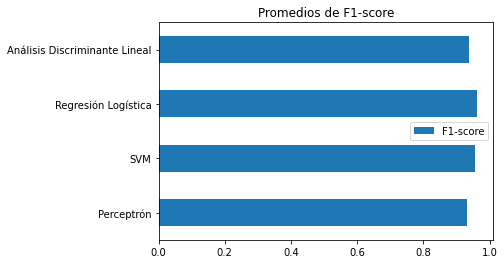

In [ ]:
techniques = ['Perceptrón', 'SVM', 'Regresión Logística', 'Análisis Discriminante Lineal']
pd.DataFrame({'F1-score': f1s}, index=techniques).plot(kind='barh', title="Promedios de F1-score")
for i in range(4): print("{}: {:.5f}".format(techniques[i], f1s[i]))

## **Segunda iteración**

Para la segunda iteración se decidió balancear las clases, de la siguiente manera: se haría un over-sampling de la clase minoritaria, de manera que esta igualara en tamaño a la clase mayoritaria. Esto se hizo con el uso de la técnica SMOTE (Synthetic Minority Oversampling Technique). Un texto de cómo hacer esto Python puede ser consultado [aquí](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) y la demostración de su funcionamiento se puede encontrar [aquí](https://arxiv.org/pdf/1106.1813.pdf).

> **Aclaraciones**: Se escogió hacer *over-sampling* de la clase minoritaria (`
notCKD`, o personas que no tengan enfermedad crónica renal) debido a que consideramos que reducir el número de registros de la clase mayoritaria al número de registros de la clase minoritaria era perder información que podía resultar crucial para decidir si un paciente tiene o no enfermedad crónica renal.

Además de hacer el *over-sampling* de la clase minoritaria se miraron otras posibilidades que creíamos iban a mejorar el desempeño de los modelos de la primera a la segunda iteración. Estos cambios que se consideraron fueron:
- **Cambio 1:** Eliminar el atributo **rbcc** (conteo de células rojas en la sangre) ya que, al igual que pcv (eliminado en la primera iteración), presentaba una alta correlación, aunque no tan alta para eliminarlo en la primera iteración.
- **Cambio 2:** Normalizar el atributo **bgr**, ya que presentaba valores mucho más grandes que los que tenía la mayoría de los demás atributos.
- **Cambio 3:** Normalizar el atributo **bu**, por la misma razón del punto anterior.
- **Cambio 4:** Normalizar ambos atributos, tanto **bu** como **bgr**, ya que queríamos saber si normlizar ambos, al tiempo, mejoraría el desempeño en la tercera iteración.
- **Cambio 5:** Eliminar datos atípicos. Al principio pensábamos que eliminar datos atípicos sería mala idea, ya que un indicador de enfermedad renal crónica pueden ser los niveles elevados de hemoglobina, por lo que estos valores atípicos de ciertos atributos podrían ser cruciales para detectar la enfermedad. Sin embargo, en la primera iteración nos ocurrió algo particular y es que cometíamos errores a la hora de escribir algunos nombres o valores en los parámetros de búsqueda del SearchGridCV y pensamos que un error lo puede cometer cualquiera, nadie es perfecto, ¿por qué una enfermera no podría equivocarse al momento de pasar los datos del examen de un paciente al *data-set* y haber colocado un dígito de más?

> **Nota importante:** Los cambios mencionados anteriormente no se hicieron uno después de otro. Lo que se hizo fue: a partir de la primera iteración separar el conjunto de datos en 5 copias exactamente iguales, a cada una de ellas se les hizo su cambio (de los mencionados en la lista anterior) y se les hizo el *over-sampling*. Esto con la finalidad de ver qué cambio se comportaba mejor que los otros.
>
> En un principio pensamos en hacer todas las posibles combinaciones. Sin embargo, al proponer varios posibles cambios, hacer el cálculo computacional de todas las posibilidades resultaba algo engorroso y costoso, tanto computacionalmente como en términos de tiempo.


In [ ]:
# Nueva separación de los datos

def separar(dataframe):
    
    X_2, y_2 = dataframe.drop('class', axis=1), dataframe['class']

    # Over-sampling minority class
    oversample = SMOTE()
    X_2, y_2 = oversample.fit_resample(X_2, y_2)

    train_test_2 = {}
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.3)
        train_test_2[i] = (X_train, X_test, y_train, y_test)
    
    return train_test_2

In [ ]:
# Posibles cambios, además de balancear las clases (over-sampling minority class con SMOTE)

def cambios():

    # Cambio 5: Borrar datos atípicos
    print("Borrar datos atípicos")
    numeric = data[numeric_att] if not ("pcv" in numeric_att) else data[numeric_att.remove("pcv")]
    sin_atipicos = numeric[(np.abs(stats.zscore(numeric)) < 3).all(axis=1)].index
    data_c5 = separar(data.loc[sin_atipicos,])
    f1_c5 = regresion(parameter_space_RL, data_c5)
    print()

    # Cambio 1: Eliminar rbcc
    print("Eliminar rbcc")
    data_c1 = separar(data.drop("rbcc", axis=1, inplace=False))
    f1_c1 = regresion(parameter_space_RL, data_c1)
    print()

    # Cambio 2: Normalizar el atributo "bgr"
    print("Normalizar el atributo bgr")
    data_c2 = deepcopy(data)
    data_c2['bgr'] = scale(data_c2['bgr'])
    data_c2 = separar(data_c2)
    f1_c2 = regresion(parameter_space_RL, data_c2)
    print()
    
    # Cambio 3: Normalizar el atributo "bu"
    print("Normalizar el atributo bu")
    data_c3 = deepcopy(data)
    data_c3['bu'] = scale(data_c3['bu'])
    data_c3 = separar(data_c3)
    f1_c3 = regresion(parameter_space_RL, data_c3)
    print()
    
    # Cambio 4: Normalizar los atributos "bgr" y "bu"
    print("Normalizar los atributos bgr y bu")
    data_c4 = deepcopy(data)
    data_c4['bgr'] = scale(data_c4['bgr'])
    data_c4['bu'] = scale(data_c4['bu'])
    data_c4 = separar(data_c4)
    f1_c4 = regresion(parameter_space_RL, data_c4)
    print()
    
    return [f1_c1, f1_c2, f1_c3, f1_c4, f1_c5], [data_c1, data_c2, data_c3, data_c4, data_c5]

mejor = cambios()

Borrar datos atípicos


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


F1-score = 0.98876
Accuracy = 0.98889



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


F1-score = 0.96774
Accuracy = 0.96667

F1-score = 0.98734
Accuracy = 0.98889

F1-score = 1.00000
Accuracy = 1.00000

F1-score = 1.00000
Accuracy = 1.00000

F1-score = 0.97030
Accuracy = 0.96667

F1-score = 0.96386
Accuracy = 0.96667

F1-score = 0.91139
Accuracy = 0.92222

F1-score = 0.96386
Accuracy = 0.96667

F1-score = 0.95349
Accuracy = 0.95556

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.95682	0.03682	0.87805	1.00000
Recall		0.98554	0.01985	0.94737	1.00000
F1-score	0.97067	0.02497	0.91139	1.00000
Accuracy	0.97222	0.02236	0.92222	1.00000

Eliminar rbcc


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


F1-score = 0.97196
Accuracy = 0.97368

F1-score = 0.96364
Accuracy = 0.96491

F1-score = 0.98276
Accuracy = 0.98246

F1-score = 1.00000
Accuracy = 1.00000

F1-score = 0.97436
Accuracy = 0.97368

F1-score = 0.99010
Accuracy = 0.99123

F1-score = 0.99187
Accuracy = 0.99123

F1-score = 1.00000
Accuracy = 1.00000

F1-score = 0.97248
Accuracy = 0.97368

F1-score = 0.96923
Accuracy = 0.96491

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.98063	0.01871	0.94643	1.00000
Recall		0.98284	0.01185	0.95455	1.00000
F1-score	0.98164	0.01249	0.96364	1.00000
Accuracy	0.98158	0.01268	0.96491	1.00000

Normalizar el atributo bgr


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


F1-score = 0.95935
Accuracy = 0.95614

F1-score = 0.94737
Accuracy = 0.94737

F1-score = 0.99065
Accuracy = 0.99123

F1-score = 0.94340
Accuracy = 0.94737

F1-score = 0.95161
Accuracy = 0.94737

F1-score = 0.97810
Accuracy = 0.97368

F1-score = 0.94737
Accuracy = 0.93860

F1-score = 0.97436
Accuracy = 0.97368

F1-score = 0.98182
Accuracy = 0.98246

F1-score = 0.99115
Accuracy = 0.99123

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.95215	0.02661	0.91304	0.98529
Recall		0.98176	0.01727	0.95161	1.00000
F1-score	0.96652	0.01778	0.94340	0.99115
Accuracy	0.96491	0.01881	0.93860	0.99123

Normalizar el atributo bu


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


F1-score = 0.98246
Accuracy = 0.98246

F1-score = 0.95413
Accuracy = 0.95614

F1-score = 0.99099
Accuracy = 0.99123

F1-score = 0.96491
Accuracy = 0.96491

F1-score = 0.98333
Accuracy = 0.98246



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


F1-score = 0.97391
Accuracy = 0.97368

F1-score = 0.97297
Accuracy = 0.97368

F1-score = 0.97638
Accuracy = 0.97368

F1-score = 0.98077
Accuracy = 0.98246

F1-score = 0.97087
Accuracy = 0.97368

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.96682	0.01921	0.93220	1.00000
Recall		0.98402	0.01857	0.94545	1.00000
F1-score	0.97507	0.00988	0.95413	0.99099
Accuracy	0.97544	0.00945	0.95614	0.99123

Normalizar los atributos bgr y bu


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


F1-score = 0.97479
Accuracy = 0.97368

F1-score = 0.95146
Accuracy = 0.95614

F1-score = 0.96226
Accuracy = 0.96491

F1-score = 0.96825
Accuracy = 0.96491

F1-score = 0.95146
Accuracy = 0.95614

F1-score = 0.98387
Accuracy = 0.98246

F1-score = 0.97196
Accuracy = 0.97368

F1-score = 0.97744
Accuracy = 0.97368

F1-score = 0.96183
Accuracy = 0.95614

F1-score = 0.95652
Accuracy = 0.95614

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.95607	0.02153	0.91667	0.98387
Recall		0.97668	0.01719	0.94231	1.00000
F1-score	0.96599	0.01055	0.95146	0.98387
Accuracy	0.96579	0.00916	0.95614	0.98246



#### **Resultados de desempeño**
En todos los cambios realizados se logró aumentar el F1-score, siendo el cambio 1 el que obtuvo mejor resultado. Sin embargo, decidimos que es mejor probar la siguiente iteración con cada uno de los datos que sufrieron estos cambios, para así analizar la mejora obtenida por cada camino.

En la gráfica que se presenta a continuación se pueden apreciar las mejoras que se obtuvieron al realizar un cambio en específico.

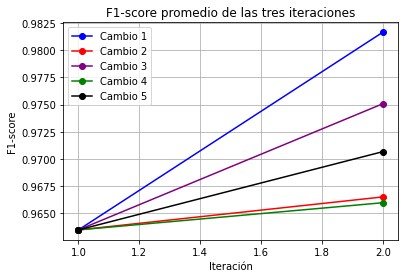


Cambio 1: Eliminar rbcc
	 -> Iteración 1: 0.96349
	 -> Iteración 2: 0.98164

Cambio 2: Normalizar bgr
	 -> Iteración 1: 0.96349
	 -> Iteración 2: 0.96652

Cambio 3: Normalizar el atributo bu
	 -> Iteración 1: 0.96349
	 -> Iteración 2: 0.97507

Cambio 4: Normalizar ambos
	 -> Iteración 1: 0.96349
	 -> Iteración 2: 0.96599

Cambio 5: Eliminar datos atípicos
	 -> Iteración 1: 0.96349
	 -> Iteración 2: 0.97067


In [ ]:
iter_names = [1, 2]

[f1_c1, f1_c2, f1_c3, f1_c4, f1_c5] = mejor[0]

iter_values = [[f1_1, f1_c1],
               [f1_1, f1_c2],
               [f1_1, f1_c3],
               [f1_1, f1_c4],
               [f1_1, f1_c5]]

iter_cambios = ["Eliminar rbcc", "Normalizar bgr", "Normalizar el atributo bu", "Normalizar ambos", "Eliminar datos atípicos"]

plt.plot(iter_names, iter_values[0], color="blue", marker="o", label="Cambio 1")
plt.plot(iter_names, iter_values[1], color="red", marker = "o", label="Cambio 2")
plt.plot(iter_names, iter_values[2], color="purple", marker = "o", label="Cambio 3")
plt.plot(iter_names, iter_values[3], color="green", marker = "o", label="Cambio 4")
plt.plot(iter_names, iter_values[4], color="black", marker = "o", label="Cambio 5")

plt.title("F1-score promedio de las tres iteraciones")
plt.xlabel("Iteración")
plt.ylabel("F1-score")
plt.legend()
plt.grid()
plt.show()

for i in range(len(iter_values)):
    print("\nCambio {}: {}".format(i+1, iter_cambios[i]))
    for k in range(2):
        print("\t -> Iteración {}: {:.5f}".format(k+1, iter_values[i][k]))


## **Tercera iteración**
Para mejorar el desempeño del clasificador en la tercera iteración se decidió aumentar el espacio de búsqueda de hiperparámetros del clasificador. Esto se hizo partiendo desde el final de la segunda iteración, es decir, se tomó cada uno de los *data-set* usados en la segunda iteración y se hizo una búsqueda más profunda de los mejores parámetros, esto con el fin de determinar qué camino del árbol (con nodo raíz en la primera iteración) resulta ser el que mejor desempeño tiene, que sea ascendente en cada iteración.

In [ ]:
# Ajustar los parámetros del clasificador

parameter_space_2 = [{'solver': ['newton-cg', 'lbfgs', 'liblinear','sag','saga'], 
                    'max_iter': [1000,3000,2000],
                    'warm_start': [False, True],
                    'C': [0.6, 0.5, 0.8, 1, 0.1, 0.4],
                    'multi_class': ['auto', 'multinomial'],
                    'tol': [1e-4, 1e-5],
                    }]

print("Eliminar rbcc")
f1_c1_3 = regresion(parameter_space_2, mejor[1][0])
print("\nNormalizar bgr")
f1_c2_3 = regresion(parameter_space_2, mejor[1][1])
print("\nNormalizar el atributo bu")
f1_c3_3 = regresion(parameter_space_2, mejor[1][2])
print("\nNormalizar ambos")
f1_c4_3 = regresion(parameter_space_2, mejor[1][3])
print("\nEliminar datos atípicos")
f1_c5_3 = regresion(parameter_space_2, mejor[1][4])

Eliminar rbcc
F1-score = 0.97196
Accuracy = 0.97368

F1-score = 0.95413
Accuracy = 0.95614

F1-score = 0.97436
Accuracy = 0.97368

F1-score = 1.00000
Accuracy = 1.00000

F1-score = 0.97436
Accuracy = 0.97368

F1-score = 0.99010
Accuracy = 0.99123

F1-score = 0.97561
Accuracy = 0.97368

F1-score = 1.00000
Accuracy = 1.00000

F1-score = 0.99083
Accuracy = 0.99123

F1-score = 0.96923
Accuracy = 0.96491

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.97904	0.01760	0.94545	1.00000
Recall		0.98123	0.01513	0.95455	1.00000
F1-score	0.98006	0.01397	0.95413	1.00000
Accuracy	0.97982	0.01417	0.95614	1.00000

Normalizar bgr
F1-score = 0.96774
Accuracy = 0.96491

F1-score = 0.94737
Accuracy = 0.94737

F1-score = 0.99065
Accuracy = 0.99123

F1-score = 0.94340
Accuracy = 0.94737

F1-score = 0.95238
Accuracy = 0.94737

F1-score = 0.98551
Accuracy = 0.98246

F1-score = 0.95455
Accuracy = 0.94737

F1-score = 0.97436
Accuracy = 0.97368

F1-score = 0.98182
Accuracy = 0.98246

F1-score = 0.99115
Accuracy =

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


F1-score = 0.99130
Accuracy = 0.99123

F1-score = 0.97297
Accuracy = 0.97368

F1-score = 0.97638
Accuracy = 0.97368

F1-score = 0.97196
Accuracy = 0.97368

F1-score = 0.97087
Accuracy = 0.97368

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.96667	0.02106	0.93220	1.00000
Recall		0.98591	0.01913	0.94545	1.00000
F1-score	0.97590	0.01097	0.95413	0.99130
Accuracy	0.97632	0.01042	0.95614	0.99123

Normalizar ambos
F1-score = 0.95798
Accuracy = 0.95614

F1-score = 0.95146
Accuracy = 0.95614

F1-score = 0.95238
Accuracy = 0.95614

F1-score = 0.96825
Accuracy = 0.96491



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


F1-score = 0.96226
Accuracy = 0.96491

F1-score = 0.97561
Accuracy = 0.97368

F1-score = 0.97196
Accuracy = 0.97368

F1-score = 0.97744
Accuracy = 0.97368

F1-score = 0.95455
Accuracy = 0.94737

F1-score = 0.96491
Accuracy = 0.96491

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.95285	0.02138	0.91304	0.98361
Recall		0.97530	0.01444	0.96078	1.00000
F1-score	0.96368	0.00904	0.95146	0.97744
Accuracy	0.96316	0.00859	0.94737	0.97368

Eliminar datos atípicos
F1-score = 0.98876
Accuracy = 0.98889

F1-score = 0.95652
Accuracy = 0.95556

F1-score = 0.97436
Accuracy = 0.97778

F1-score = 0.98113
Accuracy = 0.97778

F1-score = 0.97674
Accuracy = 0.97778

F1-score = 0.97030
Accuracy = 0.96667

F1-score = 0.96386
Accuracy = 0.96667

F1-score = 0.93506
Accuracy = 0.94444

F1-score = 0.95238
Accuracy = 0.95556

F1-score = 0.95349
Accuracy = 0.95556

Métrica		  Prom	  Desv	  Min	  Max

Precision	0.95288	0.02399	0.91111	0.97778
Recall		0.97842	0.01752	0.94737	1.00000
F1-score	0.96526	0.01529	0.93506	

#### **Resultados de desempeño**

En esta iteración se logró obtener mejoras con el **cambio 2** y el **cambio 3**. Aunque el **cambio 1** fue el que mejoró más en la segunda iteración (y mantuvo su posición como mejor F1-score global), su desempeño no subió en la tercera iteración, lo que confirma que fue una buena idea haber evaluado el desempeño en los diferentes cambios que se hicieron en la segunda iteración, para poder analizar los resultados obtenidos en los diferentes caminos que se tomaron.

En la gráfica que se muestra en el siguiente bloque se puede observar mejor estos resultados.

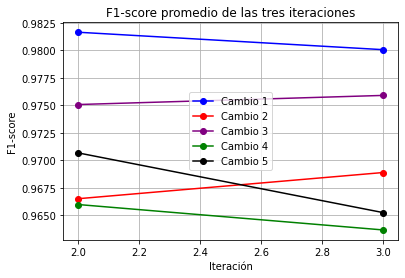


Cambio 1: Eliminar rbcc
	 -> Iteración 2: 0.98164
	 -> Iteración 3: 0.98006

Cambio 2: Normalizar bgr
	 -> Iteración 2: 0.96652
	 -> Iteración 3: 0.96889

Cambio 3: Normalizar el atributo bu
	 -> Iteración 2: 0.97507
	 -> Iteración 3: 0.97590

Cambio 4: Normalizar ambos
	 -> Iteración 2: 0.96599
	 -> Iteración 3: 0.96368

Cambio 5: Eliminar datos atípicos
	 -> Iteración 2: 0.97067
	 -> Iteración 3: 0.96526


In [ ]:
iter_names = [2, 3]

[f1_c1, f1_c2, f1_c3, f1_c4, f1_c5] = mejor[0]

iter_values = [[f1_c1, f1_c1_3],
               [f1_c2, f1_c2_3],
               [f1_c3, f1_c3_3],
               [f1_c4, f1_c4_3],
               [f1_c5, f1_c5_3]]

iter_cambios = ["Eliminar rbcc", "Normalizar bgr", "Normalizar el atributo bu", "Normalizar ambos", "Eliminar datos atípicos"]

plt.plot(iter_names, iter_values[0], color="blue", marker="o", label="Cambio 1")
plt.plot(iter_names, iter_values[1], color="red", marker = "o", label="Cambio 2")
plt.plot(iter_names, iter_values[2], color="purple", marker = "o", label="Cambio 3")
plt.plot(iter_names, iter_values[3], color="green", marker = "o", label="Cambio 4")
plt.plot(iter_names, iter_values[4], color="black", marker = "o", label="Cambio 5")

plt.title("F1-score promedio de las tres iteraciones")
plt.xlabel("Iteración")
plt.ylabel("F1-score")
plt.legend()
plt.grid()
plt.show()

for i in range(len(iter_values)):
    print("\nCambio {}: {}".format(i+1, iter_cambios[i]))
    for k in range(2):
        print("\t -> Iteración {}: {:.5f}".format(k+2, iter_values[i][k]))


## **Comparación de las tres iteraciones**

Una vez entramos a comparar el camino que tuvo cada uno de los cambios mencionados en la *Segunda Iteración* y entramos a analizar la gráfica de todos los caminos, nos podemos dar cuenta de lo siguiente:
1. Los únicos cambios que presentaron un crecimiento contínuo a lo largo de las tres iteraciones fueron el **cambio 2** y el **cambio 3**.
2. El que mejor desempeño obtuvo de los posibles cambios siguió siendo el **cambio 1**, como lo fue en la segunda iteración. Sin embargo, tuvo una leve caída en el desempeño entre la segunda y tercera iteración, lo que confirma que fue una buena idea haber evaluado el desempeño en los diferentes cambios que se hicieron en la segunda iteración, para poder analizar los resultados obtenidos en los diferentes caminos que se tomaron.

Con esto nos podemos dar cuenta que muchas veces "*más es menos"*, es decir, más cambios pueden perjudicar el desempeño en vez de mejorarlo. ¿Tal vez haber hecho todas las posibles combinaciones desde la segunda iteración pudo haber mostrado un testigo con mejor desempeño? Sí, existe esa posibilidad. Pensamos en probarlo una vez terminamos la tercera iteración pero lo consideramos bastante bien, ya que para correr solo la tercera iteración se demoraba, aproximadamente, 2hrs 30min. Por lo que probar con todas las posibilidades (al menos 24 posibilidades) resultaría sumamente demorado (¡solo con 5 fueron más de 2hrs!).

> **Nota:** los resultados sobre los mejores cambios que se realizaron dependen de la partición de los datos, por lo que si se ejecuta de nuevo, no hay garantía de que sigan siendo los mismos. 


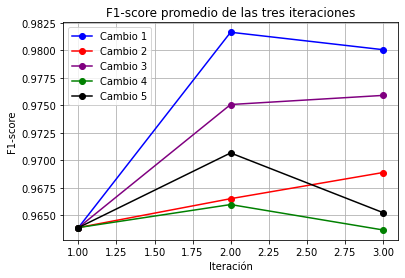


Cambio 1: Eliminar rbcc
	 -> Iteración 1: 0.96389
	 -> Iteración 2: 0.98164
	 -> Iteración 3: 0.98006

Cambio 2: Normalizar bgr
	 -> Iteración 1: 0.96389
	 -> Iteración 2: 0.96652
	 -> Iteración 3: 0.96889

Cambio 3: Normalizar el atributo bu
	 -> Iteración 1: 0.96389
	 -> Iteración 2: 0.97507
	 -> Iteración 3: 0.97590

Cambio 4: Normalizar ambos
	 -> Iteración 1: 0.96389
	 -> Iteración 2: 0.96599
	 -> Iteración 3: 0.96368

Cambio 5: Eliminar datos atípicos
	 -> Iteración 1: 0.96389
	 -> Iteración 2: 0.97067
	 -> Iteración 3: 0.96526


In [ ]:
iter_names = [1, 2, 3]

[f1_c1, f1_c2, f1_c3, f1_c4, f1_c5] = mejor[0]

iter_values = [[f1_1, f1_c1, f1_c1_3],
               [f1_1, f1_c2, f1_c2_3],
               [f1_1, f1_c3, f1_c3_3],
               [f1_1, f1_c4, f1_c4_3],
               [f1_1, f1_c5, f1_c5_3]]

iter_cambios = ["Eliminar rbcc", "Normalizar bgr", "Normalizar el atributo bu", "Normalizar ambos", "Eliminar datos atípicos"]

plt.plot(iter_names, iter_values[0], color="blue", marker="o", label="Cambio 1")
plt.plot(iter_names, iter_values[1], color="red", marker = "o", label="Cambio 2")
plt.plot(iter_names, iter_values[2], color="purple", marker = "o", label="Cambio 3")
plt.plot(iter_names, iter_values[3], color="green", marker = "o", label="Cambio 4")
plt.plot(iter_names, iter_values[4], color="black", marker = "o", label="Cambio 5")

plt.title("F1-score promedio de las tres iteraciones")
plt.xlabel("Iteración")
plt.ylabel("F1-score")
plt.legend()
plt.grid()
plt.show()

for i in range(len(iter_values)):
    print("\nCambio {}: {}".format(i+1, iter_cambios[i]))
    for k in range(3):
        print("\t -> Iteración {}: {:.5f}".format(k+1, iter_values[i][k]))
